In [1]:
import bt

In [2]:
# download data
data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')

# calculate moving average DataFrame using pandas' rolling_mean
import pandas as pd
# a rolling mean is a moving average, right?
sma = data.rolling(50).mean()

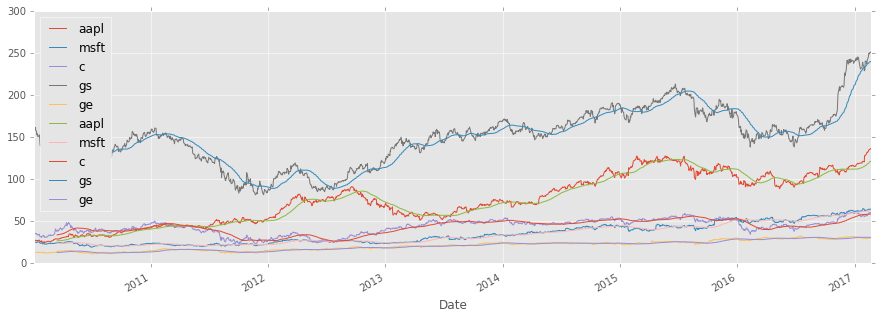

In [3]:
# let's see what the data looks like - this is by no means a pretty chart, but it does the job
plot = bt.merge(data, sma).plot(figsize=(15, 5))

In [4]:
class SelectWhere(bt.Algo):
    
    """
    Selects securities based on an indicator DataFrame.
    
    Selects securities where the value is True on the current date (target.now).
    
    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)
    
    Sets:
        * selected
    
    """
    def __init__(self, signal):
        self.signal = signal
        
    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.ix[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected
        
        # return True because we want to keep on moving down the stack
        return True

In [5]:
# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)

above50sma
0%                          100%
[############################# ] | ETA: 00:00:00

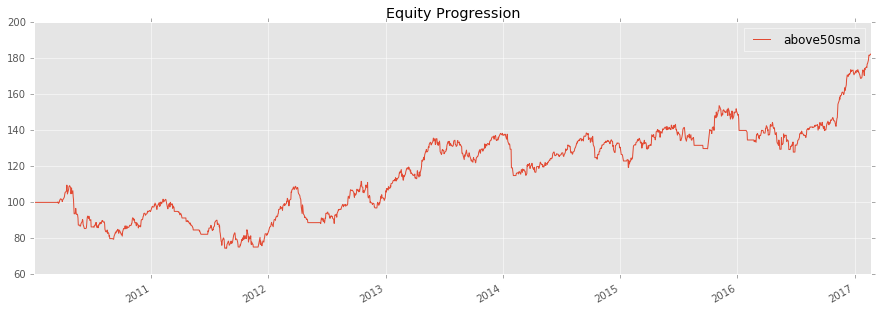

In [6]:
# what does the equity curve look like?
res.plot()

In [7]:
# and some performance stats
res.display()

Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2017-02-22
Risk-free rate       0.00%

Total Return         82.61%
Daily Sharpe         0.56
Daily Sortino        0.68
CAGR                 8.80%
Max Drawdown         -31.96%
Calmar Ratio         0.28

MTD                  7.10%
3m                   13.58%
6m                   28.80%
YTD                  6.85%
1Y                   35.60%
3Y (ann.)            16.24%
5Y (ann.)            13.20%
10Y (ann.)           8.80%
Since Incep. (ann.)  8.80%

Daily Sharpe         0.56
Daily Sortino        0.68
Daily Mean (ann.)    10.09%
Daily Vol (ann.)     18.12%
Daily Skew           -0.54
Daily Kurt           4.49
Best Day             5.78%
Worst Day            -7.99%

Monthly Sharpe       0.51
Monthly Sortino      0.72
Monthly Mean (ann.)  10.74%
Monthly Vol (ann.)   20.97%
Monthly Skew         -0.50
Monthly Kurt         0.46
Best Month           13.64%
Worst Month          -16

In [10]:
def above_sma(tickers, sma_per=50, start='2010-01-01', name='above_sma'):
    """
    Long securities that are above their n period 
    Simple Moving Averages with equal weights.
    """
    # download data
    data = bt.get(tickers, start=start)
    # calc sma
    sma = data.rolling(sma_per).mean()

    # create strategy
    s = bt.Strategy(name, [SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])    

    # now we create the backtest
    return bt.Backtest(s, data)

In [11]:
# simple backtest to test long-only allocation
def long_only_ew(tickers, start='2010-01-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
    return bt.Backtest(s, data)

# create the backtests
tickers = 'aapl,msft,c,gs,ge'
sma10 = above_sma(tickers, sma_per=10, name='sma10')
sma20 = above_sma(tickers, sma_per=20, name='sma20')
sma40 = above_sma(tickers, sma_per=40, name='sma40')
benchmark = long_only_ew('spy', name='spy')

# run all the backtests!
res2 = bt.run(sma10, sma20, sma40, benchmark)

sma10
0%                          100%
[############################# ] | ETA: 00:00:00sma20
0%                          100%
[############################# ] | ETA: 00:00:00sma40
0%                          100%
[############################# ] | ETA: 00:00:00spy
0%                          100%
[############################# ] | ETA: 00:00:00

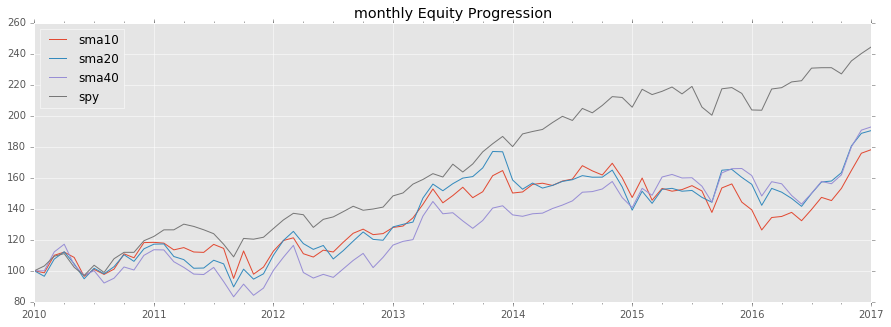

In [13]:
res2.plot(freq='m')

In [14]:
res2.display()

Stat                 sma10       sma20       sma40       spy
-------------------  ----------  ----------  ----------  ----------
Start                2010-01-03  2010-01-03  2010-01-03  2010-01-03
End                  2017-02-22  2017-02-22  2017-02-22  2017-02-22
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         77.09%      103.52%     106.10%     140.56%
Daily Sharpe         0.52        0.65        0.67        0.88
Daily Sortino        0.63        0.79        0.84        1.13
CAGR                 8.34%       10.47%      10.66%      13.09%
Max Drawdown         -26.87%     -26.94%     -32.56%     -18.60%
Calmar Ratio         0.31        0.39        0.33        0.70

MTD                  6.62%       6.85%       6.86%       3.85%
3m                   15.24%      12.92%      15.09%      7.75%
6m                   30.05%      30.43%      31.39%      9.31%
YTD                  8.03%       7.86%       8.05%       5.70%
1Y                   48.12%      39.04

In [15]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.
    
    Args:
        * target_weights (DataFrame): DataFrame containing the target weights
    
    Sets:
        * weights
    
    """
    
    def __init__(self, target_weights):
        self.tw = target_weights
    
    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.ix[target.now]                

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()
        
        # return True because we want to keep on moving down the stack
        return True

In [16]:
## download some data & calc SMAs
data = bt.get('spy', start='2010-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()
# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0
# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0

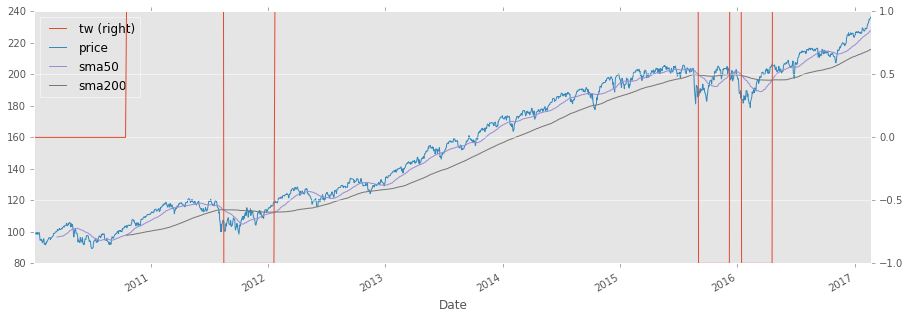

In [17]:
# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

In [18]:
ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)

ma_cross
0%                          100%
[############################# ] | ETA: 00:00:00

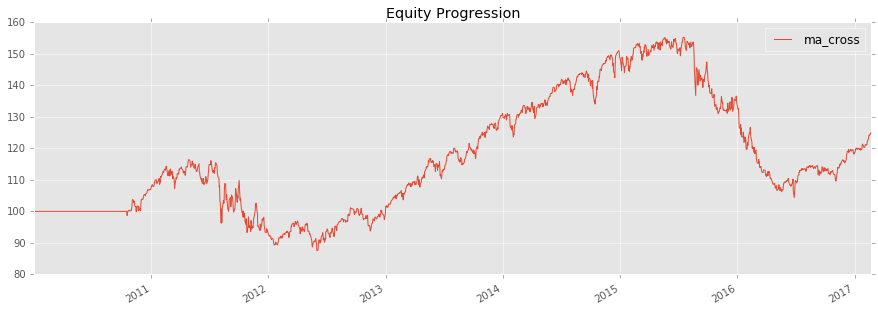

In [19]:
res.plot()

In [20]:
# first let's create a helper function to create a ma cross backtest
def ma_cross(ticker, start='2010-01-01', 
             short_ma=50, long_ma=200, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0    
    tw[long_sma.isnull()] = 0.0
    
    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

# ok now let's create a few backtests and gather the results.
# these will later become our "synthetic securities"
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

# let's run these strategies now
res = bt.run(t1, t2)

# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res['aapl_ma_cross'].prices, res['msft_ma_cross'].prices)

# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)

aapl_ma_cross
0%                          100%
[############################# ] | ETA: 00:00:00msft_ma_cross
0%                          100%
[############################# ] | ETA: 00:00:00s
0%                          100%
[############################# ] | ETA: 00:00:00

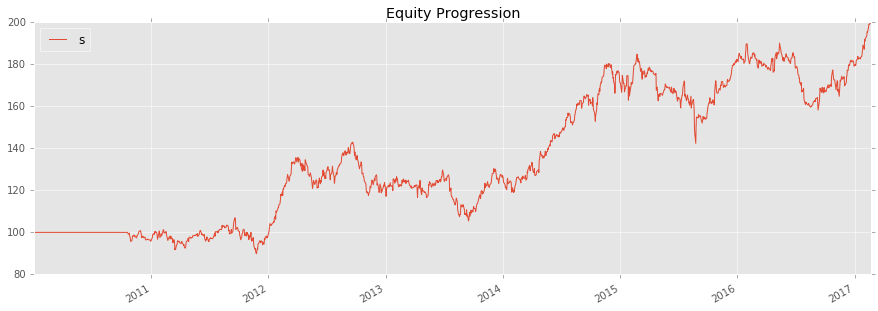

In [21]:
res.plot()

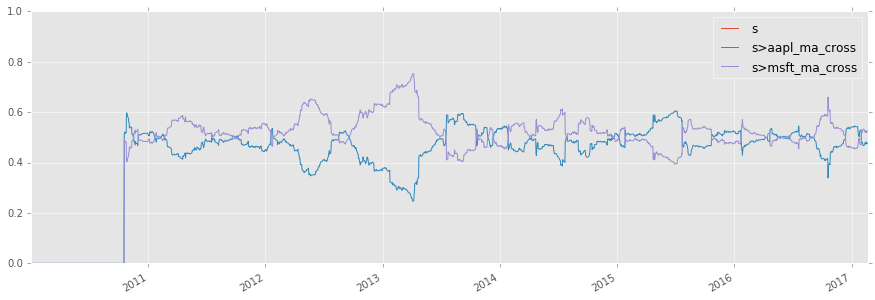

In [22]:
res.plot_weights()

In [23]:
# once again, we will create a few backtests
# these will be the child strategies
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

# let's extract the data object
data = bt.merge(t1.data, t2.data)

# now we create the parent strategy
# we specify the children to be the two 
# strategies created above
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()],
                [t1.strategy, t2.strategy])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)

s
0%                          100%
[############################# ] | ETA: 00:00:00

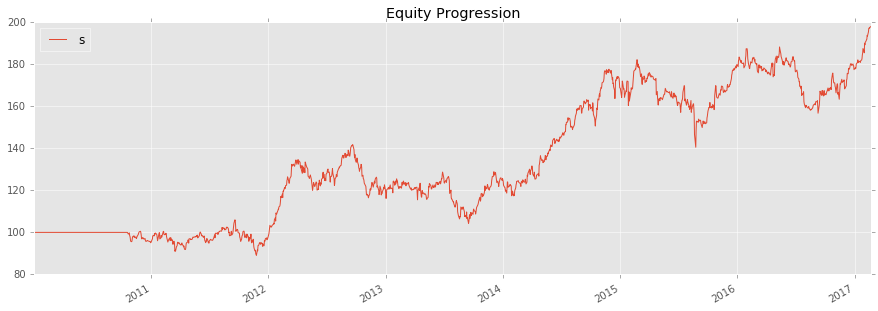

In [24]:
res.plot()

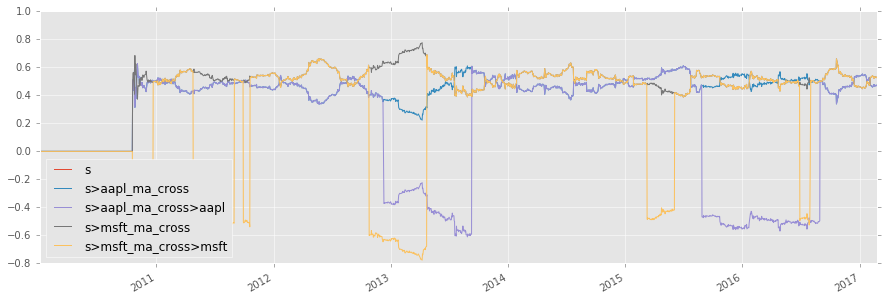

In [25]:
res.plot_weights()